In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw

In [2]:
def create_prob_matrix(game, home, away):
    # returns calculated result probability matrix and total xG values for both teams

    grouped=game.groupby("Squad")
    shots=[]
    home_xG = away_xG = 0.0 # in case a team has no shots
    # calculate total xG for both teams
    for team, frame in grouped:
        if home in team:
            home_xG = sum(frame["xG"])
        elif away in team:
            away_xG = sum(frame["xG"])
        shots.append(len(frame))

    # set up probability matrix
    n=max(shots)
    I = np.identity(n+1)
    I[n,n] = 0
    I = np.roll(I,1, axis=1).T
    result_probs = np.zeros([n+1,n+1])
    result_probs[n,n] = 1

    #calculate the matrix
    for index, row in game.iterrows():
        xG = row["xG"]
        if home in row["Squad"]:
            score = np.matmul(result_probs,xG*I)
            miss = np.matmul((1-xG)*np.identity(n+1),result_probs)
            result_probs = score + miss
        elif away in row["Squad"]:
            score = np.matmul(xG*I.T,result_probs)
            miss = np.matmul((1-xG)*np.identity(n+1),result_probs)
            result_probs = score + miss
        else:
            print("ERROR: Check for team names!")
            return
    result_probs = np.rot90(result_probs,2)
    return result_probs, home_xG, away_xG

In [3]:
def highlight_cell(x,y, ax=None, **kwargs):
    # highlights a cell with rectangle of given color
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

In [7]:
def prob_chart(url):
    # generates basic graphic visualizing result probability

    # set up data
    df = pd.read_html(url)
    home=df[2].columns[0][0]
    away=df[2].columns[1][0]
    home_goals = sum(df[16].iloc[:,5])
    away_goals = sum(df[9].iloc[:,5])
    game=df[17]
    game.columns = game.columns.droplevel()
    game=game[["Squad","xG"]]
    game=game.dropna()
    game["xG"] = pd.to_numeric(game["xG"])

    # get probabilities
    result_probs, home_xG, away_xG = create_prob_matrix(game, home, away)

    # calculate probability for home win/away win/draw
    remis_prob = sum(np.diag(result_probs))
    home_prob = sum(sum(np.triu(result_probs)))-remis_prob
    away_prob = sum(sum(np.tril(result_probs)))-remis_prob

    # find most likely result
    most_likely_result = np.roll(list(np.unravel_index(result_probs.argmax(),result_probs.shape)),1)
    max_prob = result_probs.max()

    # get probability for actual result
    prob_actual = result_probs[away_goals,home_goals]

    # visualize probability matrix
    limit_r_p = max(6,max(home_goals,away_goals)+1)
    fig, ax = plt.subplots(figsize=(3,3))
    ax = plt.imshow(result_probs[:limit_r_p,:limit_r_p],cmap="Greens")

    # highlight diagonal cells (draw) and actual result
    for i in range(limit_r_p):
        highlight_cell(i,i,color="yellow")
    highlight_cell(home_goals,away_goals, color="red", linewidth=2)

    title_font = {'fontname':'corbel','fontsize':13}
    label_font = {'fontname':'corbel','fontsize':12}
    plt.title(f"Result Probability Chart",**title_font)
    plt.xlabel(f"{home} Goals",**label_font)
    plt.ylabel(f"{away} Goals",**label_font)
    plt.tight_layout()
    plt.colorbar()
    background_col = "lightyellow"
    fig.set_facecolor(background_col)
    filename = f"graphics/{home}_{away}_goalprob.png"
    plt.savefig(filename, facecolor = background_col, edgecolor="none")

    return home, away, home_goals, away_goals, home_xG, away_xG, prob_actual, most_likely_result, max_prob, home_prob, away_prob, remis_prob, result_probs, filename

In [17]:
def viz_game(url):
    # generates graphic with result probability chart and additional info

    # creates base graphic with only probability chart
    home, away, home_goals, away_goals, home_xG, away_xG, prob_actual, most_likely_result, max_prob, home_prob, away_prob, remis_prob, result_probs, filename = prob_chart(url)
    im = Image.open(filename)
    width = 620
    height = 350
    viz = Image.new("RGB",(width,height),"lightyellow")
    viz.paste(im, (5,50))
    viz.save(filename)

    # adds additional info
    font = ImageFont.truetype("calibri.ttf", 28)
    im = Image.open(filename)
    draw = ImageDraw.Draw(im)
    text = f"{home} - {away}  {home_goals}:{away_goals}"
    length = list(draw.textbbox((0,0),text, font=font))[2]
    draw.multiline_text(((width-length)/2, 20),text, font=font, fill=(0,0,0), align="center")

    font = ImageFont.truetype("calibri.ttf", 18)
    text = f"xG: {round(home_xG,2)}:{round(away_xG,2)}\n"\
           f"Most Likely Result: {most_likely_result[0]}:{most_likely_result[1]} with {round(max_prob*100,1)}%\n"\
           f"Actual Result Probability: {round(prob_actual*100,1)}%\n"\
           f"Probability Home Win: {round(home_prob*100,1)}%\n"\
           f"Probability Draw: {round(remis_prob*100,1)}%\n"\
           f"Probability Away Win: {round(away_prob*100,1)}%"
    draw.multiline_text(((width/2)+15, 85),text, font=font, fill=(0,0,0), align="left",spacing=20)

    # adds data source info
    font = ImageFont.truetype("calibri.ttf", 12)
    text = "by: Yannik Holzer\n"\
           "data from FBRef\n"\
           "xG from Opta"
    length = list(draw.textbbox((0,0),text, font=font))[2]
    height_text = list(draw.textbbox((0,0),text, font=font))[3]
    draw.multiline_text((width-length-10, height-height_text-10),text, font=font, fill=(0,0,0), align="left")

    im.save(filename)

In [6]:
#prob_chart("https://fbref.com/en/matches/e0c1ddb1/Manchester-City-Real-Madrid-April-26-2022-Champions-League")

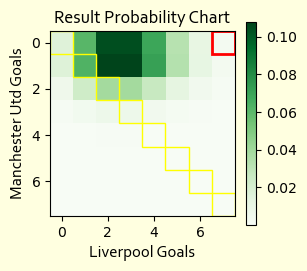

In [18]:
viz_game("https://fbref.com/en/matches/756e8036/North-West-Derby-Liverpool-Manchester-United-March-5-2023-Premier-League")

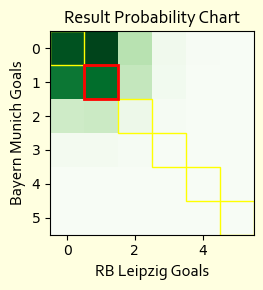

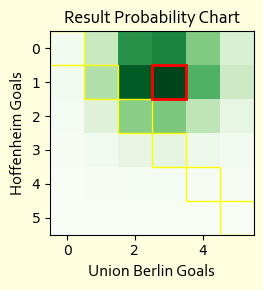

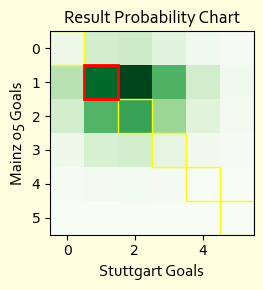

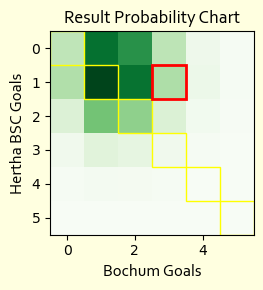

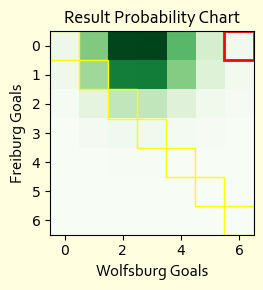

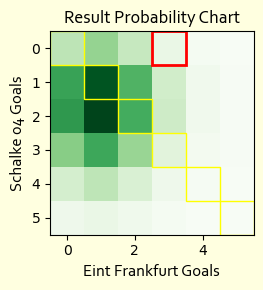

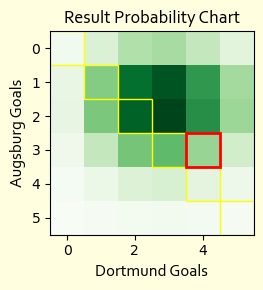

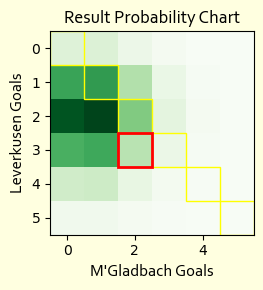

In [8]:
md15=["https://fbref.com/en/matches/e54e4723/RB-Leipzig-Bayern-Munich-January-20-2023-Bundesliga","https://fbref.com/en/matches/56a7d0d0/Union-Berlin-Hoffenheim-January-21-2023-Bundesliga","https://fbref.com/en/matches/908285ca/Stuttgart-Mainz-05-January-21-2023-Bundesliga","https://fbref.com/en/matches/9fe9e678/Bochum-Hertha-BSC-January-21-2023-Bundesliga","https://fbref.com/en/matches/cb069426/Wolfsburg-Freiburg-January-21-2023-Bundesliga","https://fbref.com/en/matches/d731c369/Eintracht-Frankfurt-Schalke-04-January-21-2023-Bundesliga","https://fbref.com/en/matches/33175b1b/Dortmund-Augsburg-January-22-2023-Bundesliga","https://fbref.com/en/matches/deef21aa/Monchengladbach-Bayer-Leverkusen-January-22-2023-Bundesliga"]

for match in md15:
    viz_game(match)